In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2

from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras.models import Sequential
from keras import backend as K
from keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Dropout

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.applications import resnet
from keras.applications.vgg16 import VGG16
from keras.models import Model

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
base_path = 'E:/DATASET EXPERIMENT/Resize exp'

In [4]:
SIZE = 160
image_size = (SIZE, SIZE)
batch_size = 32
channels = 3
kernel = 4
stride = 1
pool = 2

(160, 160, 3)


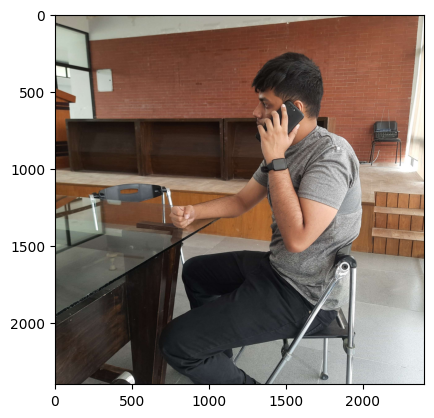

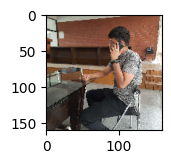

In [5]:
#show resized images
img = cv2.imread("E:/DATASET EXPERIMENT/Resize/Calling/20240425_085451 (resize).jpg")[:, :, ::-1]
width, height = SIZE, SIZE
resized_img = cv2.resize(img, (width, height))
plt.imshow(img)
plt.figure(figsize = (1.5, 1.5))
plt.imshow(resized_img)
print(resized_img.shape)

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_path,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size = image_size,
    batch_size = batch_size,
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_path,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = image_size,
    batch_size = batch_size,
)

Found 2500 files belonging to 10 classes.
Using 2000 files for training.
Found 2500 files belonging to 10 classes.
Using 500 files for validation.


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.2,
    shear_range = 0.2,
    horizontal_flip= True,
    vertical_flip= False,
    validation_split= 0.2,
)
test_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split= 0.2,
)

In [8]:
train_set = train_datagen.flow_from_directory(
    base_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode= 'categorical',
    shuffle = True,
    subset = 'training'
)
test_set = train_datagen.flow_from_directory(
    base_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode= 'categorical',
    shuffle = False,
    subset = 'validation'
)

Found 2000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [9]:
test_set.class_indices

{'Calling': 0,
 'Cheating': 1,
 'Climbing': 2,
 'Consuming': 3,
 'LisentingMusic': 4,
 'Sitting': 5,
 'Standing': 6,
 'Studying': 7,
 'Talking': 8,
 'Teaching': 9}

In [10]:
class_names = train_ds.class_names
num_classes = len(class_names)
class_names

['Calling',
 'Cheating',
 'Climbing',
 'Consuming',
 'LisentingMusic',
 'Sitting',
 'Standing',
 'Studying',
 'Talking',
 'Teaching']

In [11]:
labels = ['Calling','Cheating','Climbing','Consuming','LisentingMusic','Sitting','Standing','Studying','Talking','Teaching']

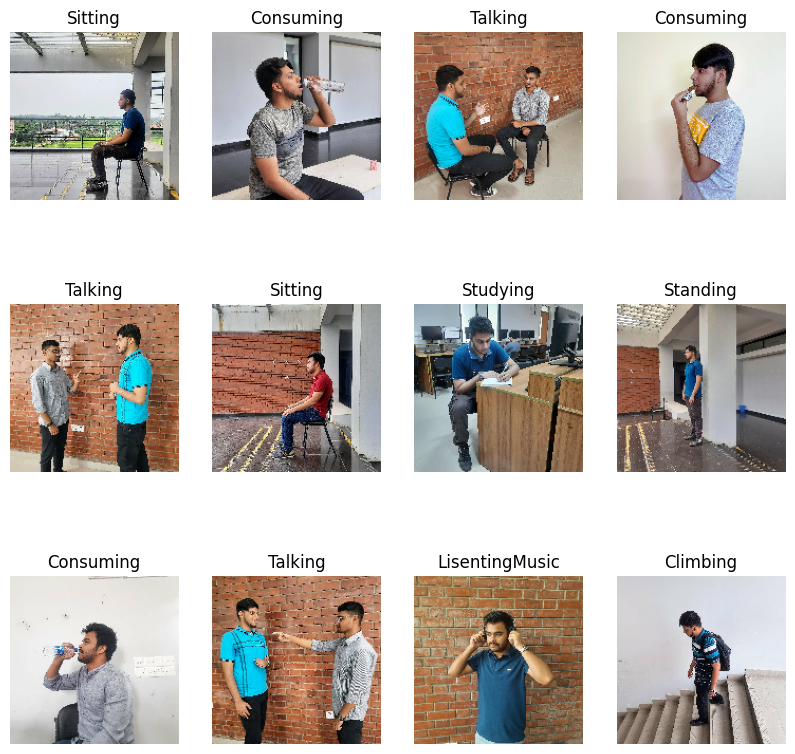

In [12]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in train_ds.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[i]])
    plt.axis("off")

#VGG16 Model


In [13]:
vgg_model = Sequential()

pretrained_model= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(160,160,3),
                   pooling='avg',classes=num_classes,
                   weights='imagenet')

for layer in pretrained_model.layers:
        layer.trainable=False

vgg_model.add(pretrained_model)
vgg_model.add(Flatten())
vgg_model.add(Dense(512, activation='relu'))
vgg_model.add(Dense(10, activation='softmax'))

vgg_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [18]:
history = vgg_model.fit(
  train_set,
  validation_data=test_set,
  epochs=25
)

Epoch 1/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.6001 - loss: 1.4204 - val_accuracy: 0.5860 - val_loss: 1.3142
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.7751 - loss: 0.8547 - val_accuracy: 0.6340 - val_loss: 1.0865
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.8117 - loss: 0.6897 - val_accuracy: 0.6860 - val_loss: 0.9576
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.8327 - loss: 0.5638 - val_accuracy: 0.7080 - val_loss: 0.8626
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.8521 - loss: 0.4857 - val_accuracy: 0.7100 - val_loss: 0.8006
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.8747 - loss: 0.4145 - val_accuracy: 0.7520 - val_loss: 0.7095
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.8867 - loss: 0.3876 - val_accuracy: 0.7620 - val_loss: 0.6912
Epoch 8/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.8976 - loss: 0.3324 - val_accuracy: 0.7540 - v

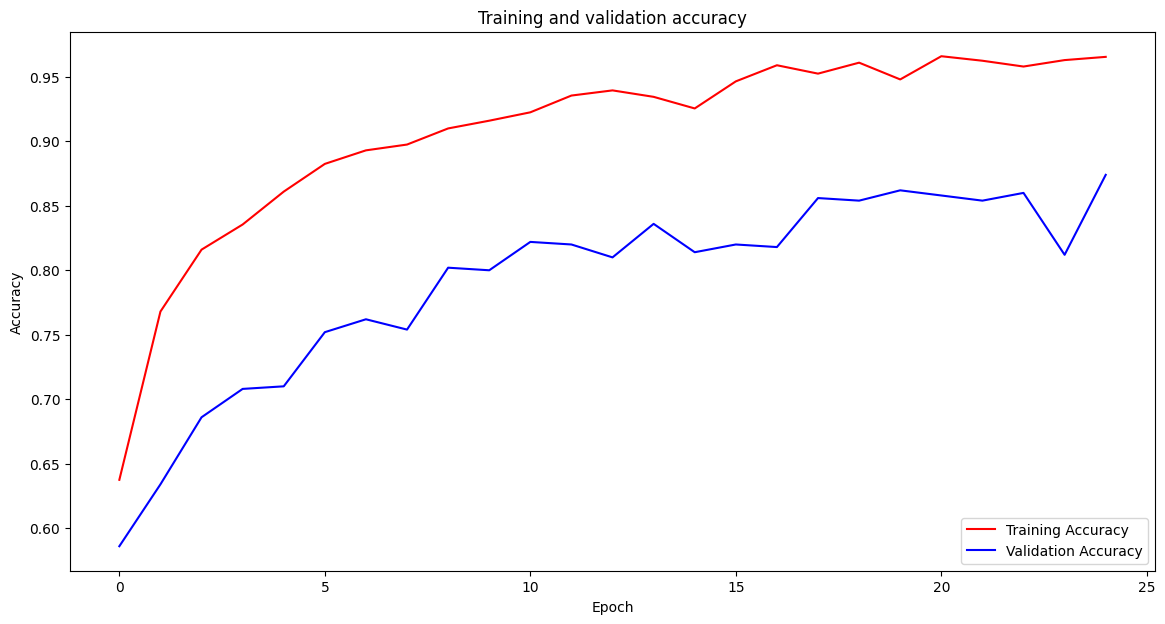

In [19]:
# Validation and Training accuracy plot
import matplotlib.pyplot as plt

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

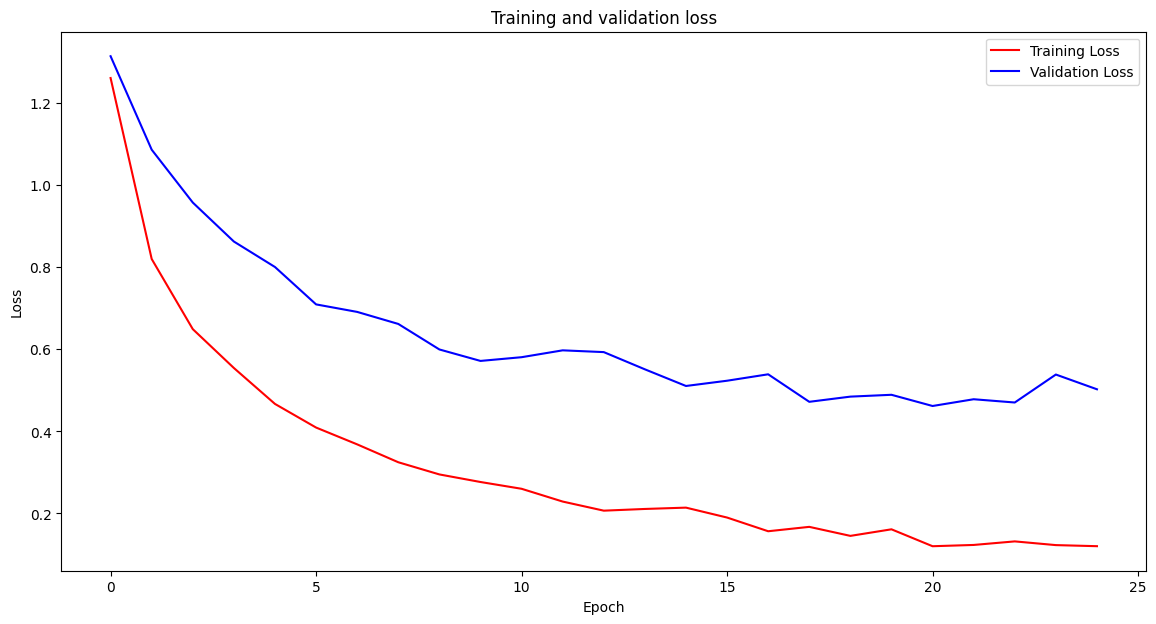

In [20]:
#Validation and Training loss plot
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [21]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)  # Use 'img' instead of 'image_batch[i]'
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


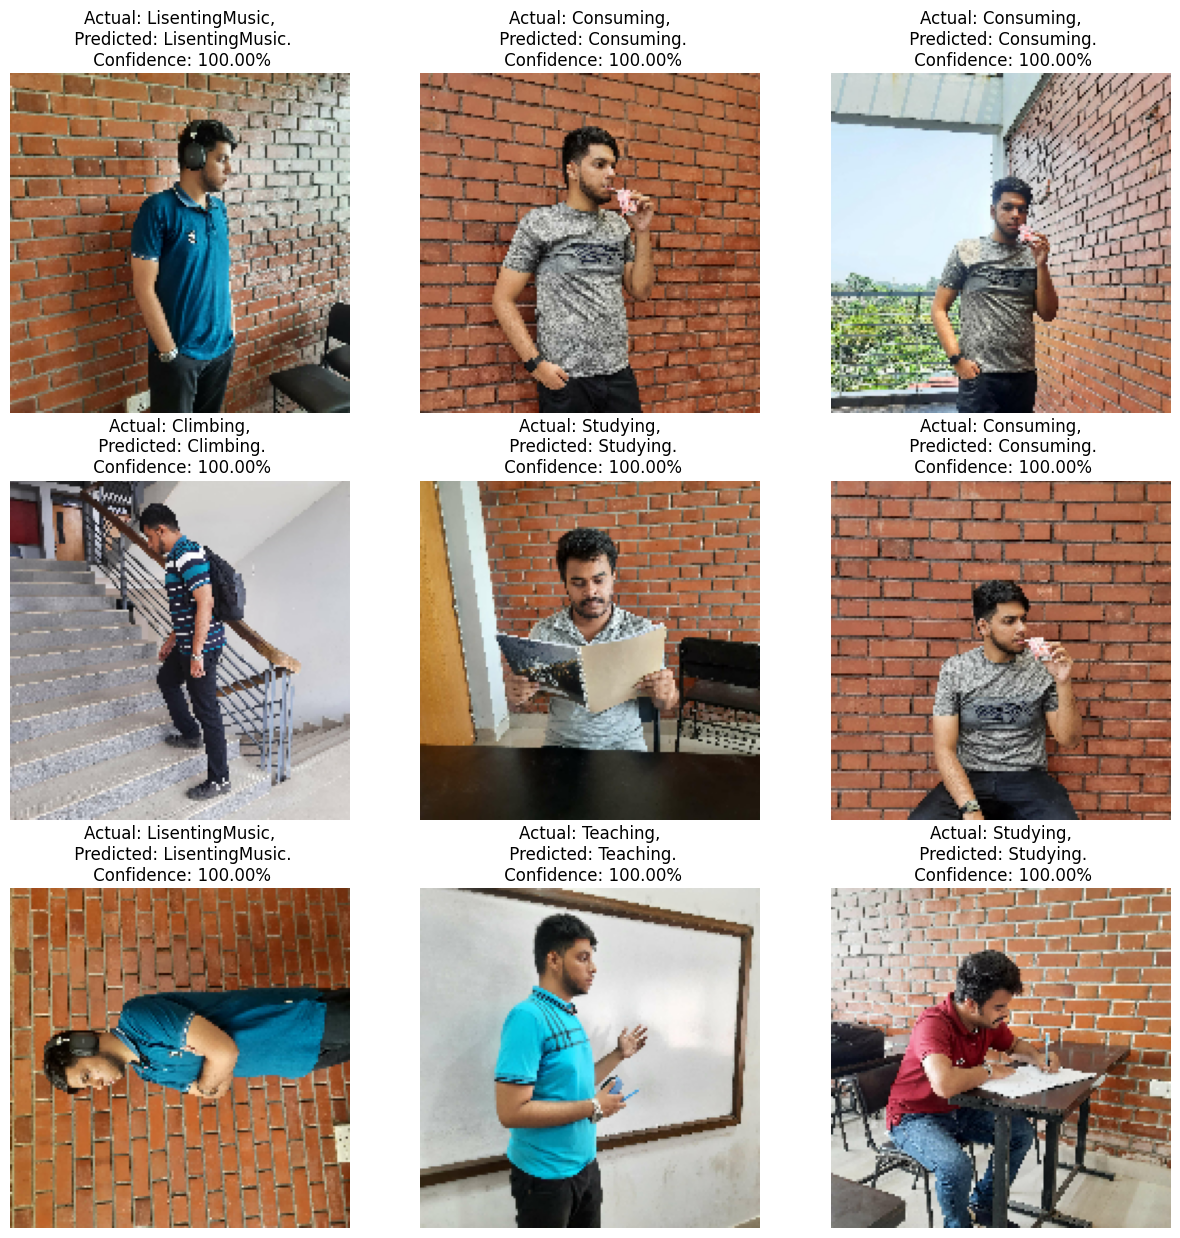

In [22]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(vgg_model, image_batch[i].numpy())
        actual_class = class_names[labels_batch[i]] 
        confidence_percent = "{:.2f}%".format(confidence)  # Format confidence as a percentage with two decimal places
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence_percent}")
        plt.axis("off")


In [23]:
loss,test_accuracy = vgg_model.evaluate(test_set)
print('Accuracy on test:', test_accuracy)
print('Loss on test set:', loss)

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7770 - loss: 0.9804
Accuracy on test: 0.8799999952316284
Loss on test set: 0.4758014380931854


In [24]:
# T0 print the Classification Report
y_pred = vgg_model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(test_set.classes, y_pred))

16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step
              precision    recall  f1-score   support

           0       0.94      0.64      0.76        50
           1       0.92      0.90      0.91        50
           2       1.00      0.90      0.95        50
           3       0.83      0.96      0.89        50
           4       0.82      0.74      0.78        50
           5       0.85      0.92      0.88        50
           6       0.85      0.88      0.86        50
           7       0.80      0.96      0.87        50
           8       0.98      1.00      0.99        50
           9       0.90      0.94      0.92        50

    accuracy                           0.88       500
   macro avg       0.89      0.88      0.88       500
weighted avg       0.89      0.88      0.88       500



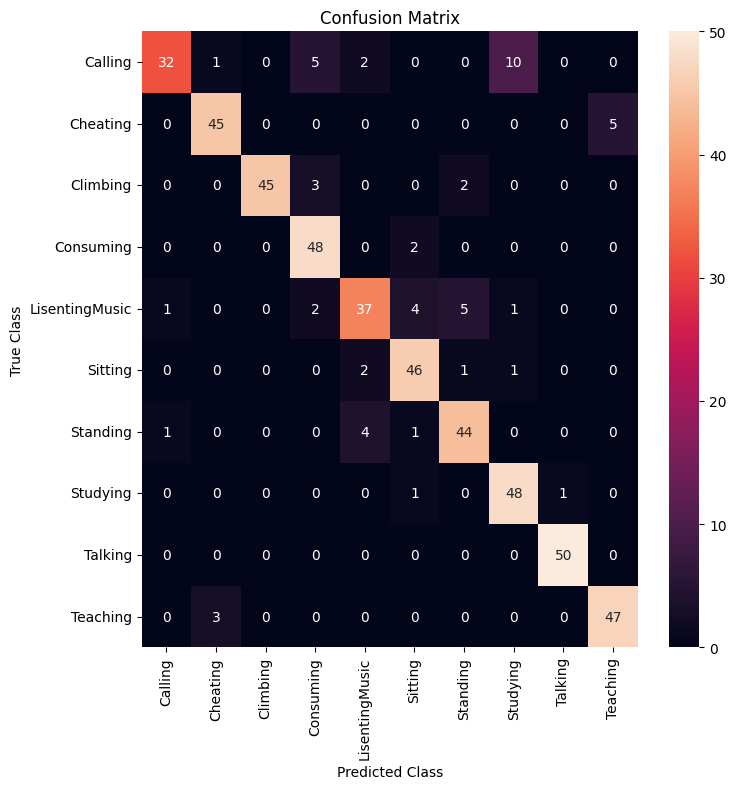

In [25]:
import seaborn as sns
# To print the Confusion Matrix
cf_matrix = confusion_matrix(test_set.classes, y_pred)
labels = ['Calling','Cheating','Climbing','Consuming','LisentingMusic','Sitting','Standing','Studying','Talking','Teaching']
plt.figure(figsize=(8, 8))
heatmap = sns.heatmap(cf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt='d', color='blue')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

In [17]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping  # Import EarlyStopping

base_path = 'E:/DATASET EXPERIMENT/Resize exp'
SIZE = 160
image_size = (SIZE, SIZE)
batch_size = 32
num_classes = 10  # Assuming you have 10 classes

# Define class names
class_names = ['Calling', 'Cheating', 'Climbing', 'Consuming', 'LisentingMusic', 'Sitting', 'Standing', 'Studying', 'Talking', 'Teaching']

# Function to create VGG model
def create_vgg_model():
    vgg_model = Sequential()
    pretrained_model = tf.keras.applications.VGG16(include_top=False,
                                                    input_shape=(160, 160, 3),
                                                    pooling='avg',
                                                    classes=num_classes,
                                                    weights='imagenet')

    for layer in pretrained_model.layers:
        layer.trainable = False

    vgg_model.add(pretrained_model)
    vgg_model.add(Flatten())
    vgg_model.add(Dense(512, activation='relu'))
    vgg_model.add(Dense(num_classes, activation='softmax'))

    vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return vgg_model

# Load data using ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

# Load all images and labels into arrays
def load_images_and_labels(base_path, image_size, class_names):
    images = []
    labels = []
    for class_index, class_name in enumerate(class_names):
        class_path = os.path.join(base_path, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            image = cv2.imread(image_path)
            image = cv2.resize(image, image_size)
            images.append(image)
            labels.append(class_index)
    return np.array(images), np.array(labels)

images, labels = load_images_and_labels(base_path, image_size, class_names)
labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)



Fold 1...
Epoch 1/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.3596 - loss: 1.9626 - val_accuracy: 0.7160 - val_loss: 1.1117 - learning_rate: 0.0010
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.7760 - loss: 0.9293 - val_accuracy: 0.8040 - val_loss: 0.7554 - learning_rate: 0.0010
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.8237 - loss: 0.6320 - val_accuracy: 0.8420 - val_loss: 0.5833 - learning_rate: 0.0010
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.8883 - loss: 0.4628 - val_accuracy: 0.8720 - val_loss: 0.4524 - learning_rate: 0.0010
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9133 - loss: 0.3684 - val_accuracy: 0.8740 - val_loss: 0.4429 - learning_rate: 1.0000e-05
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9277 - loss: 0.3555 - val_accuracy: 0.8840 - val_loss: 0.4385 - learning_rate: 1.0000e-05
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9199 - loss: 0.349

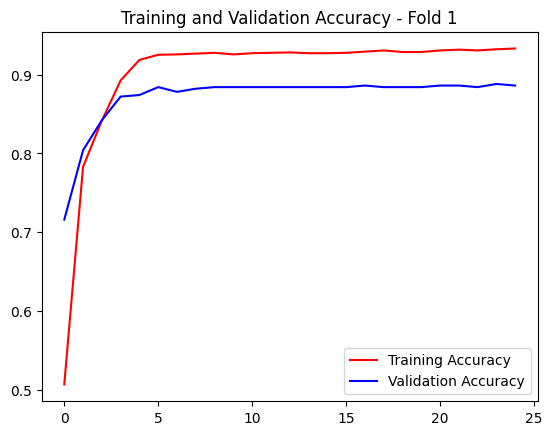

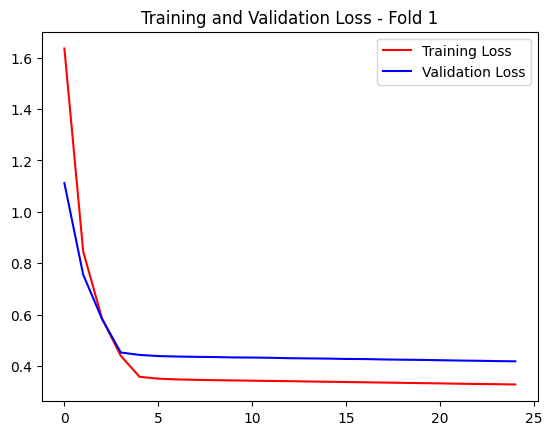

Fold 2...
Epoch 1/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.3627 - loss: 1.9571 - val_accuracy: 0.7220 - val_loss: 1.1083 - learning_rate: 0.0010
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.7696 - loss: 0.9395 - val_accuracy: 0.8200 - val_loss: 0.7183 - learning_rate: 0.0010
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.8659 - loss: 0.5909 - val_accuracy: 0.8380 - val_loss: 0.5469 - learning_rate: 0.0010
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.8854 - loss: 0.4667 - val_accuracy: 0.8600 - val_loss: 0.4673 - learning_rate: 0.0010
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9153 - loss: 0.3622 - val_accuracy: 0.8620 - val_loss: 0.4433 - learning_rate: 1.0000e-05
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9268 - loss: 0.3411 - val_accuracy: 0.8680 - val_loss: 0.4347 - learning_rate: 1.0000e-05
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9311 - loss: 0.358

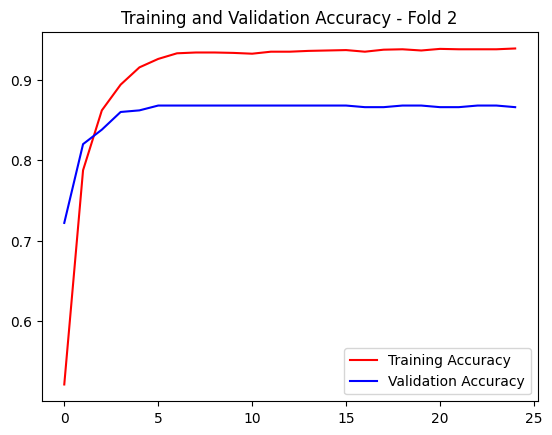

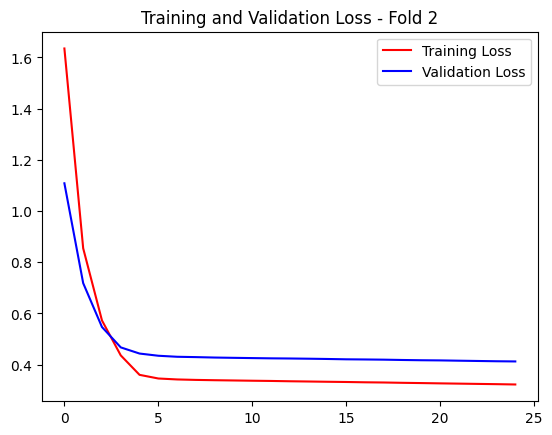

Fold 3...
Epoch 1/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.3565 - loss: 1.9601 - val_accuracy: 0.7140 - val_loss: 1.1111 - learning_rate: 0.0010
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.7482 - loss: 0.9830 - val_accuracy: 0.7720 - val_loss: 0.7660 - learning_rate: 0.0010
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.8230 - loss: 0.6676 - val_accuracy: 0.8220 - val_loss: 0.6304 - learning_rate: 0.0010
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8565 - loss: 0.4970 - val_accuracy: 0.8740 - val_loss: 0.4753 - learning_rate: 0.0010
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9062 - loss: 0.3948 - val_accuracy: 0.8800 - val_loss: 0.4592 - learning_rate: 1.0000e-05
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9153 - loss: 0.3671 - val_accuracy: 0.8860 - val_loss: 0.4522 - learning_rate: 1.0000e-05
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9159 - loss: 0.359

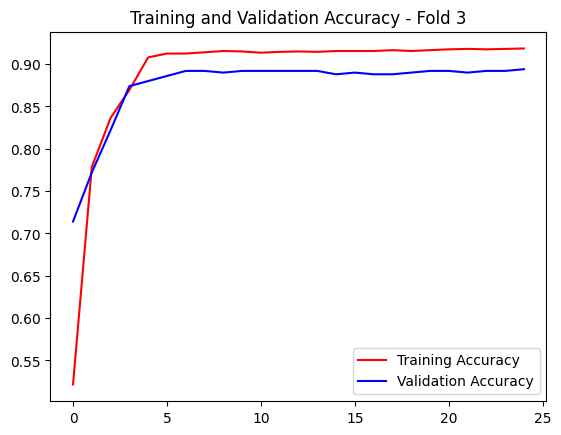

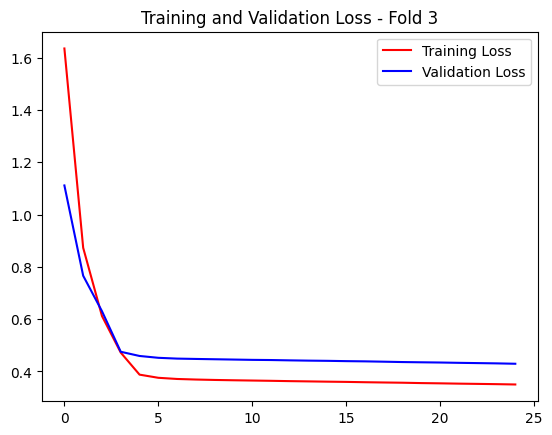

Fold 4...
Epoch 1/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.3189 - loss: 1.9799 - val_accuracy: 0.6140 - val_loss: 1.1997 - learning_rate: 0.0010
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.7418 - loss: 0.9775 - val_accuracy: 0.8380 - val_loss: 0.6908 - learning_rate: 0.0010
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.8508 - loss: 0.6345 - val_accuracy: 0.8680 - val_loss: 0.5409 - learning_rate: 0.0010
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.8889 - loss: 0.4789 - val_accuracy: 0.9000 - val_loss: 0.4250 - learning_rate: 0.0010
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9034 - loss: 0.4061 - val_accuracy: 0.9100 - val_loss: 0.4101 - learning_rate: 1.0000e-05
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9229 - loss: 0.3583 - val_accuracy: 0.9080 - val_loss: 0.4061 - learning_rate: 1.0000e-05
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9147 - loss: 0.368

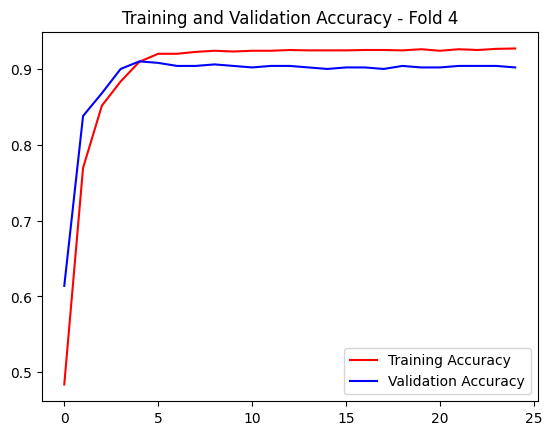

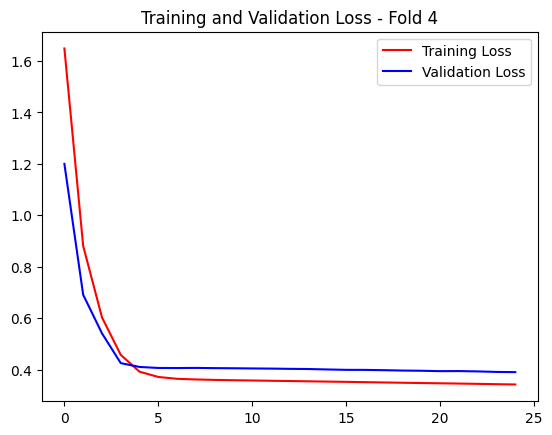

Fold 5...
Epoch 1/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.3837 - loss: 1.9291 - val_accuracy: 0.7580 - val_loss: 1.0807 - learning_rate: 0.0010
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7742 - loss: 0.9215 - val_accuracy: 0.8040 - val_loss: 0.7375 - learning_rate: 0.0010
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.8427 - loss: 0.6221 - val_accuracy: 0.8460 - val_loss: 0.5511 - learning_rate: 0.0010
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9012 - loss: 0.4427 - val_accuracy: 0.8640 - val_loss: 0.4535 - learning_rate: 0.0010
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9214 - loss: 0.3640 - val_accuracy: 0.8760 - val_loss: 0.4324 - learning_rate: 1.0000e-05
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9185 - loss: 0.3543 - val_accuracy: 0.8820 - val_loss: 0.4246 - learning_rate: 1.0000e-05
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9196 - loss: 0.358

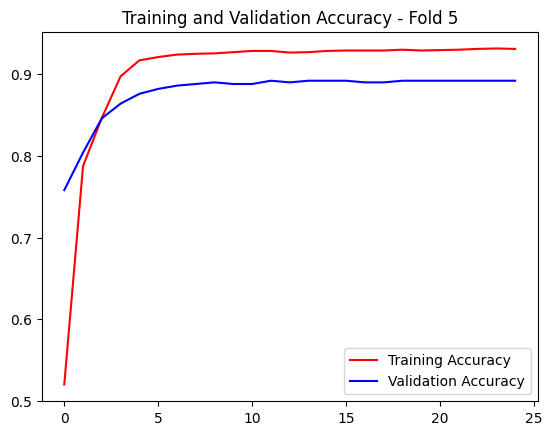

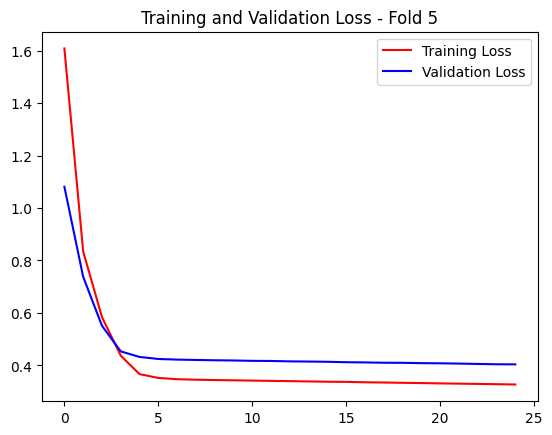

Fold 1 - Accuracy: 0.8859999775886536, Loss: 0.4179987907409668
Fold 2 - Accuracy: 0.8659999966621399, Loss: 0.41247090697288513
Fold 3 - Accuracy: 0.8939999938011169, Loss: 0.42945265769958496
Fold 4 - Accuracy: 0.9020000100135803, Loss: 0.3899662494659424
Fold 5 - Accuracy: 0.8920000195503235, Loss: 0.40403005480766296
Mean Accuracy: 0.8879999995231629, Mean Loss: 0.41078373193740847


In [24]:
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import KFold


# Initialize KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
# Initialize lists to store results
accuracy_per_fold = []
loss_per_fold = []




# Define a learning rate schedule function
def lr_schedule(epoch):
    learning_rate = 0.001
    if epoch > 3:
        learning_rate = 0.00001
    return learning_rate

# Loop through each fold
fold_no = 1
for train_index, val_index in kfold.split(images, labels):  # Provide labels to KFold.split()
    print(f'Fold {fold_no}...')
    
    # Split data into train and validation sets for this fold
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]

    # Create ImageDataGenerators for training and validation sets
    train_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow(train_images, train_labels, batch_size=batch_size)
    val_generator = val_datagen.flow(val_images, val_labels, batch_size=batch_size)

    # Create and compile VGG model
    vgg_model = create_vgg_model()

    # Define Learning Rate Scheduler callback
    lr_scheduler = LearningRateScheduler(lr_schedule)

    # Train the model with learning rate schedule
    history = vgg_model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=25,
        callbacks=[lr_scheduler]  # Add learning rate scheduler callback here
    )

    # Evaluate the model on test set
    loss, accuracy = vgg_model.evaluate(val_generator, verbose=0)
    print(f'Accuracy for Fold {fold_no}: {accuracy}')
    print(f'Loss for Fold {fold_no}: {loss}')
    
    # Append accuracy and loss to lists
    accuracy_per_fold.append(accuracy)
    loss_per_fold.append(loss)

    # Plot training history for this fold
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy - Fold {fold_no}')
    plt.legend()
    plt.show()

    # Plot loss
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title(f'Training and Validation Loss - Fold {fold_no}')
    plt.legend()
    plt.show()

    fold_no += 1

# Calculate mean accuracy and loss
mean_accuracy = np.mean(accuracy_per_fold)
mean_loss = np.mean(loss_per_fold)

# Display each fold's results
for i in range(len(accuracy_per_fold)):
    print(f"Fold {i+1} - Accuracy: {accuracy_per_fold[i]}, Loss: {loss_per_fold[i]}")

print(f"Mean Accuracy: {mean_accuracy}, Mean Loss: {mean_loss}")
